# Project 7: Future Sales Prediction

**Type:** Regression | **Level:** Intermediate

Predict next-month item sales per shop for the Kaggle competition `Predict Future Sales`.

**Model:** XGBoost Regressor

**Dataset:** [Kaggle Competition](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data)

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Data

In [2]:
# Load the datasets
sales_train = pd.read_csv('../data/future_sales/sales_train.csv')
test = pd.read_csv('../data/future_sales/test.csv')
items = pd.read_csv('../data/future_sales/items.csv')
shops = pd.read_csv('../data/future_sales/shops.csv')
item_categories = pd.read_csv('../data/future_sales/item_categories.csv')

print(f"Sales train shape: {sales_train.shape}")
print(f"Test shape: {test.shape}")
print(f"Items shape: {items.shape}")
print(f"Shops shape: {shops.shape}")
print(f"Item categories shape: {item_categories.shape}")
print(f"\nFirst few rows of sales_train:")
sales_train.head()

Sales train shape: (2935849, 6)
Test shape: (214200, 3)
Items shape: (22170, 3)
Shops shape: (60, 2)
Item categories shape: (84, 2)

First few rows of sales_train:


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## 3. Exploratory Data Analysis

Dataset Info:
Rows: 2935849, Columns: 6

Data types:
date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

Missing values: 0

Target variable (item_cnt_day) statistics:
count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


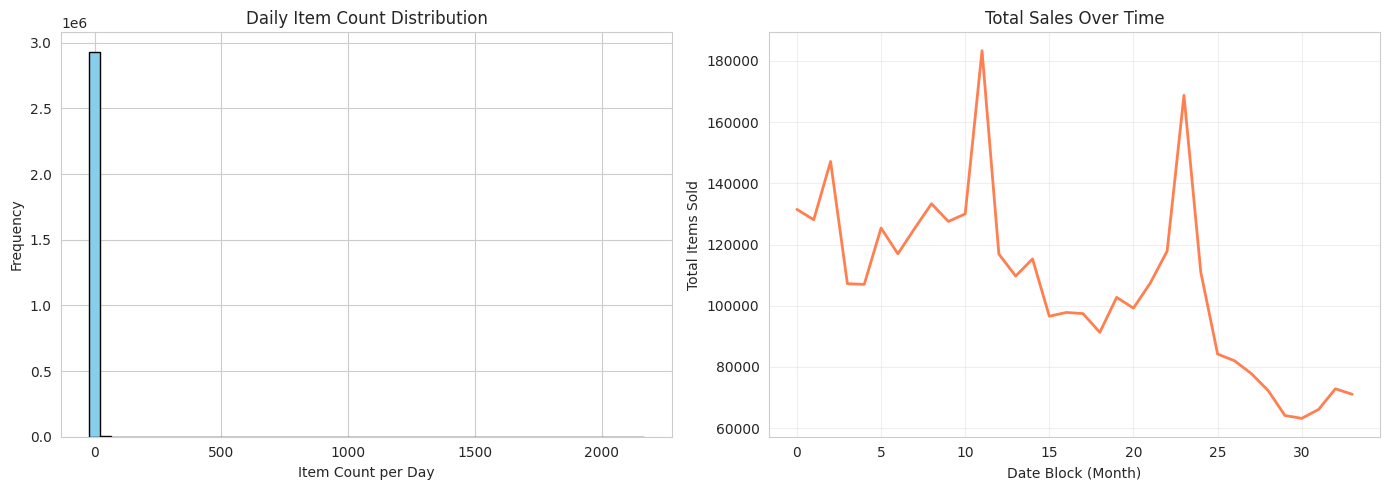

In [3]:
# Basic info
print("Dataset Info:")
print(f"Rows: {sales_train.shape[0]}, Columns: {sales_train.shape[1]}")
print(f"\nData types:\n{sales_train.dtypes}")
print(f"\nMissing values: {sales_train.isnull().sum().sum()}")
print(f"\nTarget variable (item_cnt_day) statistics:")
print(sales_train['item_cnt_day'].describe())

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Item count distribution
axes[0].hist(sales_train['item_cnt_day'], bins=50, edgecolor='black', color='skyblue')
axes[0].set_title('Daily Item Count Distribution')
axes[0].set_xlabel('Item Count per Day')
axes[0].set_ylabel('Frequency')

# Sales over time (by date_block_num)
monthly_sales = sales_train.groupby('date_block_num')['item_cnt_day'].sum()
axes[1].plot(monthly_sales.index, monthly_sales.values, color='coral', linewidth=2)
axes[1].set_title('Total Sales Over Time')
axes[1].set_xlabel('Date Block (Month)')
axes[1].set_ylabel('Total Items Sold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Data Preprocessing

In [4]:
# Aggregate daily sales to monthly
sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg(
    item_cnt_month=('item_cnt_day', 'sum')
)

# Clip extreme values (competition guideline)
sales_monthly['item_cnt_month'] = sales_monthly['item_cnt_month'].clip(0, 20)

# Merge with item categories
sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

print(f"Monthly sales shape: {sales_monthly.shape}")
print(f"\nDate blocks range: {sales_monthly['date_block_num'].min()} to {sales_monthly['date_block_num'].max()}")
print(f"\nSample of processed data:")
sales_monthly.head()

Monthly sales shape: (1609124, 5)

Date blocks range: 0 to 33

Sample of processed data:


,date_block_num,shop_id,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57


## 5. Model Training

In [5]:
# Create lag features for the last month
sales_monthly_lag = sales_monthly.copy()
sales_monthly_lag['date_block_num'] += 1
sales_monthly_lag = sales_monthly_lag.rename(columns={'item_cnt_month': 'item_cnt_month_lag_1'})
sales_monthly_lag = sales_monthly_lag[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month_lag_1']]

# Merge lag features
sales_monthly = sales_monthly.merge(sales_monthly_lag, on=['date_block_num', 'shop_id', 'item_id'], how='left')
sales_monthly['item_cnt_month_lag_1'] = sales_monthly['item_cnt_month_lag_1'].fillna(0)

# Split into train and validation (last month as validation)
train_data = sales_monthly[sales_monthly['date_block_num'] < 33]
val_data = sales_monthly[sales_monthly['date_block_num'] == 33]

# Prepare features and target
feature_cols = ['shop_id', 'item_id', 'item_category_id', 'item_cnt_month_lag_1']
X_train = train_data[feature_cols]
y_train = train_data['item_cnt_month']
X_val = val_data[feature_cols]
y_val = val_data['item_cnt_month']

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

# Train XGBoost model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

print("\nModel trained successfully!")

Training set size: 1577593
Validation set size: 31531

Model trained successfully!


## 6. Model Evaluation

Model Performance:
Training RMSE: 2.0427
Validation RMSE: 2.1020

Training MAE: 1.0458
Validation MAE: 1.0862

Training R²: 0.3725
Validation R²: 0.3140


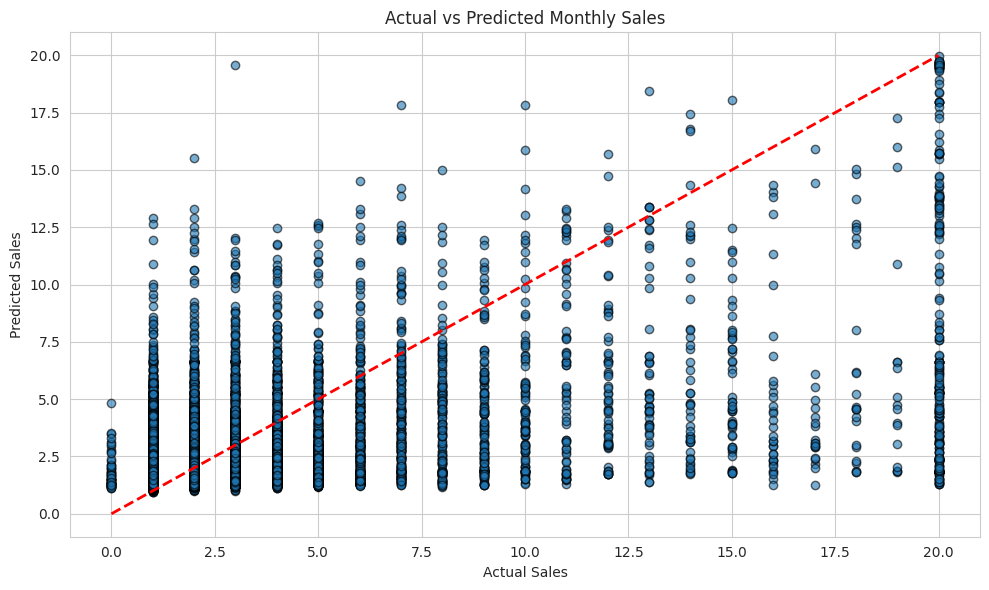

In [6]:
# Make predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Clip predictions to valid range
y_val_pred = np.clip(y_val_pred, 0, 20)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

print("Model Performance:")
print("="*50)
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"\nTraining MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"\nTraining R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6, edgecolors='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Monthly Sales')
plt.tight_layout()
plt.show()

## 7. Save Model

In [7]:
# Save the trained model
model_path = '../models/future_sales_model.pkl'
joblib.dump(model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save feature names for future use
feature_data = {
    'feature_names': feature_cols,
    'sales_monthly': sales_monthly
}
feature_path = '../models/future_sales_features.pkl'
joblib.dump(feature_data, feature_path)
print(f"✓ Feature info saved to: {feature_path}")

print("\n" + "="*50)
print("Model training complete!")
print("="*50)
print("\nTo use the model later:")
print("  model = joblib.load('../models/future_sales_model.pkl')")
print("  prediction = model.predict(new_data)")

✓ Model saved to: ../models/future_sales_model.pkl
✓ Feature info saved to: ../models/future_sales_features.pkl

Model training complete!

To use the model later:
  model = joblib.load('../models/future_sales_model.pkl')
  prediction = model.predict(new_data)
